# Import

In [84]:
import gymnasium as gym
import numpy as np
import torch    
from stable_baselines3 import SAC
from pendulum_env_simple import MuJoCoPendulumEnv
import matplotlib.pyplot as plt
import numpy as np

In [85]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
env = MuJoCoPendulumEnv() 

Using device: cpu


/opt/anaconda3/envs/rl_venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/anaconda3/envs/rl_venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [86]:
class ActionGaussianNoiseWrapper(gym.Wrapper):
    def __init__(self, env, snr_linear=20.0):
        super().__init__(env)
        self.snr_linear = snr_linear

    def step(self, action):
        # action shape: (1,)
        signal_power = np.mean(action**2) + 1e-8

        # Noise power from SNR definition
        noise_power = signal_power / self.snr_linear
        noise_std = np.sqrt(noise_power)

        noise = np.random.normal(0.0, noise_std, size=action.shape)
        action_noisy = action + noise

        return self.env.step(action_noisy)


In [87]:
def rollout_sb3_debug(env, model, seed=0, max_steps=500, start_angle=None, start_velocity=None):
    # Prepare reset options
    reset_kwargs = {}
    if seed is not None:
        reset_kwargs['seed'] = seed
    
    if start_angle is not None:
        options = {'start_angle': start_angle}
        if start_velocity is not None:
            options['start_velocity'] = start_velocity
        reset_kwargs['options'] = options
    
    state, _ = env.reset(**reset_kwargs)
    done = False
    
    states = [state]
    actions = []
    rewards = []
    step = 0
    
    while not done and step < max_steps:
        action, _ = model.predict(state, deterministic=True)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        step += 1
        
        if done:
            print(f"Episode ended at step {step}")
            print(f"Terminated: {terminated}, Truncated: {truncated}")
            print(f"Final state: {state}")
            break
    
    return np.array(states), np.array(actions), np.array(rewards)

# Simple SAC

In [88]:
# Create the base noisy environment (used for all rollouts)
base_env = MuJoCoPendulumEnv()
env_noisy = ActionGaussianNoiseWrapper(base_env, snr_linear=10)

In [89]:
# Train simple SAC on noisy env (no penalty)
model_simple = SAC(
    "MlpPolicy",
    env_noisy,
    learning_rate=3e-4,
    gamma=0.99,
    # verbose=1,
)

In [90]:
model_simple.learn(total_timesteps=100_000)

In [91]:
# Rollout on base noisy env (no penalty wrapper)
states_45_simple, actions_45_simple, rewards_45_simple = rollout_sb3_debug(env_noisy, model_simple, start_angle=np.pi/4, start_velocity=0.0)

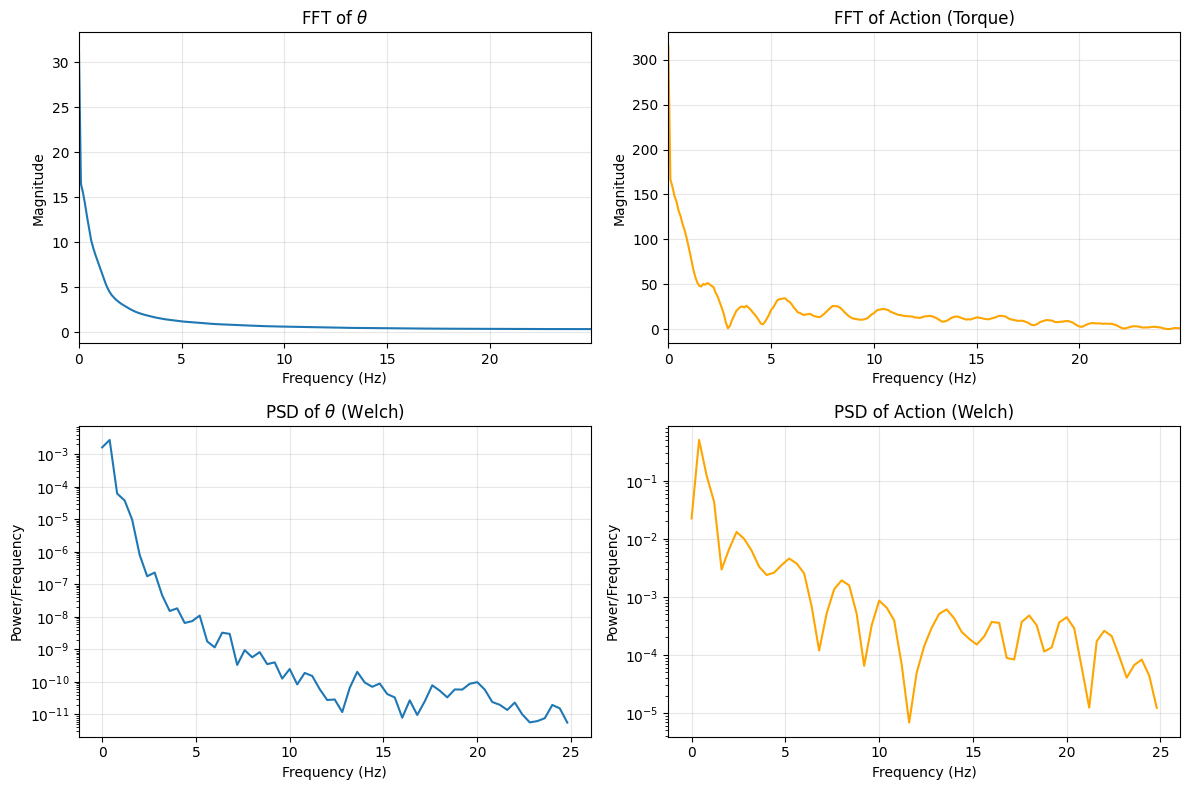

In [92]:
from scipy.fft import fft, fftfreq
from scipy.signal import welch

# Compute and plot FFT of states and actions

dt = env_noisy.unwrapped.dt  # timestep
n_samples = len(actions_45_simple)

# Compute FFT frequencies
freqs = fftfreq(n_samples, dt)[:n_samples // 2]

# Compute theta and action signals
theta = np.arctan2(states_45_simple[:-1, 1], states_45_simple[:-1, 0])  # atan2(sin, cos)
action_signal = actions_45_simple.flatten()

# Compute Power Spectral Density (PSD) using Welch's method
freqs_psd, psd_theta = welch(theta, fs=1/dt, nperseg=len(theta)//4)
freqs_psd, psd_action = welch(action_signal, fs=1/dt, nperseg=len(action_signal)//4)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# FFT plots (top row)
ax = axes[0, 0]
fft_vals = np.abs(fft(theta))[:n_samples // 2]
ax.plot(freqs, fft_vals)
ax.set_title(r'FFT of $\theta$')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
fft_actions = np.abs(fft(action_signal))[:n_samples // 2]
ax.plot(freqs, fft_actions, color='orange')
ax.set_title('FFT of Action (Torque)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

# PSD plots (bottom row)
ax = axes[1, 0]
ax.semilogy(freqs_psd, psd_theta)
ax.set_title(r'PSD of $\theta$ (Welch)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.semilogy(freqs_psd, psd_action, color='orange')
ax.set_title('PSD of Action (Welch)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Reducing Noise LPF

In [93]:
from scipy.signal import butter, lfilter, lfilter_zi

class HighFrequencyPenaltyWrapper(gym.Wrapper):
    """
    Penalizes action frequencies above a cutoff (default 10Hz).
    Uses a high-pass filter to extract high-frequency components and penalizes them.
    """
    def __init__(
        self,
        env,
        fs=20.0,           # sampling frequency (Hz)
        cutoff_hz=10.0,    # penalize frequencies above this
        lambda_hf=0.1,     # penalty weight for high-frequency content
    ):
        super().__init__(env)
        
        self.lambda_hf = lambda_hf
        self.fs = fs
        self.cutoff_hz = cutoff_hz
        
        # Design a high-pass Butterworth filter to detect high-frequency components
        nyq = 0.5 * fs
        normalized_cutoff = cutoff_hz / nyq
        # Clamp to valid range (0, 1) for filter design
        normalized_cutoff = min(max(normalized_cutoff, 0.01), 0.99)
        self.b, self.a = butter(2, normalized_cutoff, btype="high")
        self.zi = lfilter_zi(self.b, self.a)
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Reset filter state
        self.zi = lfilter_zi(self.b, self.a)
        return obs, info
    
    def step(self, action):
        u = float(action[0])
        action_env = np.array([u], dtype=np.float32)
        
        obs, reward, terminated, truncated, info = self.env.step(action_env)
        
        # Extract high-frequency component of the action
        u_hf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_hf = u_hf[0]
        
        # Penalize high-frequency content (squared to make it smooth and always positive)
        hf_penalty = -self.lambda_hf * u_hf**2
        
        reward += hf_penalty
        
        return obs, reward, terminated, truncated, info

In [94]:
# Wrap noisy env with LPF penalty for training
env_LPF = HighFrequencyPenaltyWrapper(env_noisy, cutoff_hz=10.0, lambda_hf=0.1)

In [95]:
model_LPF = SAC(
    "MlpPolicy",
    env_LPF,
    learning_rate=3e-4,
    gamma=0.99,
    # verbose=1,
)

In [96]:
# model_LPF.learn(total_timesteps=100_000)

In [97]:
# Rollout on base noisy env (no penalty wrapper)
states_45_LPF, actions_45_LPF, rewards_45_LPF = rollout_sb3_debug(env_noisy, model_LPF, start_angle=np.pi/4, start_velocity=0.0)

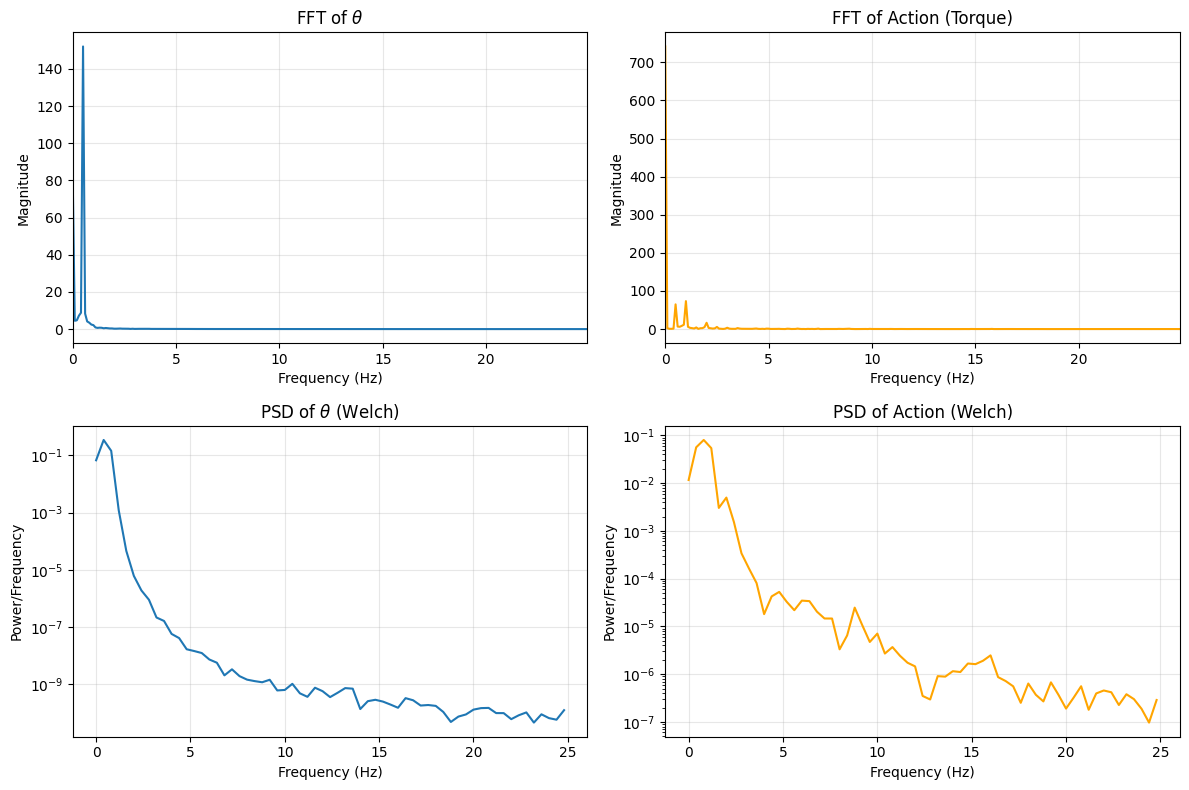

In [98]:
from scipy.fft import fft, fftfreq
from scipy.signal import welch

# Compute and plot FFT of states and actions

dt = env_noisy.unwrapped.dt  # timestep
n_samples = len(actions_45_LPF)

# Compute FFT frequencies
freqs = fftfreq(n_samples, dt)[:n_samples // 2]

# Compute theta and action signals
theta = np.arctan2(states_45_LPF[:-1, 1], states_45_LPF[:-1, 0])  # atan2(sin, cos)
action_signal = actions_45_LPF.flatten()

# Compute Power Spectral Density (PSD) using Welch's method
freqs_psd, psd_theta = welch(theta, fs=1/dt, nperseg=len(theta)//4)
freqs_psd, psd_action = welch(action_signal, fs=1/dt, nperseg=len(action_signal)//4)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# FFT plots (top row)
ax = axes[0, 0]
fft_vals = np.abs(fft(theta))[:n_samples // 2]
ax.plot(freqs, fft_vals)
ax.set_title(r'FFT of $\theta$')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
fft_actions = np.abs(fft(action_signal))[:n_samples // 2]
ax.plot(freqs, fft_actions, color='orange')
ax.set_title('FFT of Action (Torque)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

# PSD plots (bottom row)
ax = axes[1, 0]
ax.semilogy(freqs_psd, psd_theta)
ax.set_title(r'PSD of $\theta$ (Welch)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.semilogy(freqs_psd, psd_action, color='orange')
ax.set_title('PSD of Action (Welch)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sigmoided Penalty

In [99]:
class SigmoidFrequencyPenaltyWrapper(gym.Wrapper):
    """
    Penalizes high-frequency action content using a sigmoid-based score.
    The high-pass filter output is passed through a sigmoid to get a score in [0, 1],
    which is then used as the penalty.
    """
    def __init__(
        self,
        env,
        fs=20.0,           # sampling frequency (Hz)
        cutoff_hz=10.0,    # penalize frequencies above this
        lambda_penalty=1.0, # penalty weight
        sigmoid_scale=1.0,  # controls steepness of sigmoid (higher = steeper)
    ):
        super().__init__(env)
        
        self.lambda_penalty = lambda_penalty
        self.sigmoid_scale = sigmoid_scale
        self.fs = fs
        self.cutoff_hz = cutoff_hz
        
        # Design a high-pass Butterworth filter to detect high-frequency components
        nyq = 0.5 * fs
        normalized_cutoff = cutoff_hz / nyq
        # Clamp to valid range (0, 1) for filter design
        normalized_cutoff = min(max(normalized_cutoff, 0.01), 0.99)
        self.b, self.a = butter(2, normalized_cutoff, btype="high")
        self.zi = lfilter_zi(self.b, self.a)
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Reset filter state
        self.zi = lfilter_zi(self.b, self.a)
        return obs, info
    
    def _sigmoid(self, x):
        """Sigmoid function mapping x^2 to [0, 1]"""
        # Use x^2 to make it symmetric around 0
        return 1.0 / (1.0 + np.exp(-self.sigmoid_scale * x**2))
    
    def step(self, action):
        u = float(action[0])
        action_env = np.array([u], dtype=np.float32)
        
        obs, reward, terminated, truncated, info = self.env.step(action_env)
        
        # Extract high-frequency component of the action
        u_hf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_hf = u_hf[0]
        
        # Compute sigmoid score in [0, 1] based on high-frequency content
        hf_score = self._sigmoid(u_hf)
        
        penalty = -self.lambda_penalty * hf_score
        
        reward += penalty  # Add to task reward, don't replace
        
        # Store score in info for debugging
        info['hf_score'] = hf_score
        info['hf_component'] = u_hf
        
        return obs, reward, terminated, truncated, info

In [100]:
# Wrap noisy env with sigmoid penalty for training
env_sigmoid = SigmoidFrequencyPenaltyWrapper(env_noisy, cutoff_hz=10.0, lambda_penalty=0.1)

In [101]:
model_sigmoided = SAC(
    "MlpPolicy",
    env_sigmoid,
    learning_rate=3e-4,
    gamma=0.99,
    # verbose=1,
)

In [102]:
model_sigmoided.learn(total_timesteps=100_000)

In [103]:
# Rollout on base noisy env (no penalty wrapper)
states_45_sig, actions_45_sig, rewards_45_sig = rollout_sb3_debug(env_noisy, model_sigmoided, start_angle=np.pi/4, start_velocity=0.0)

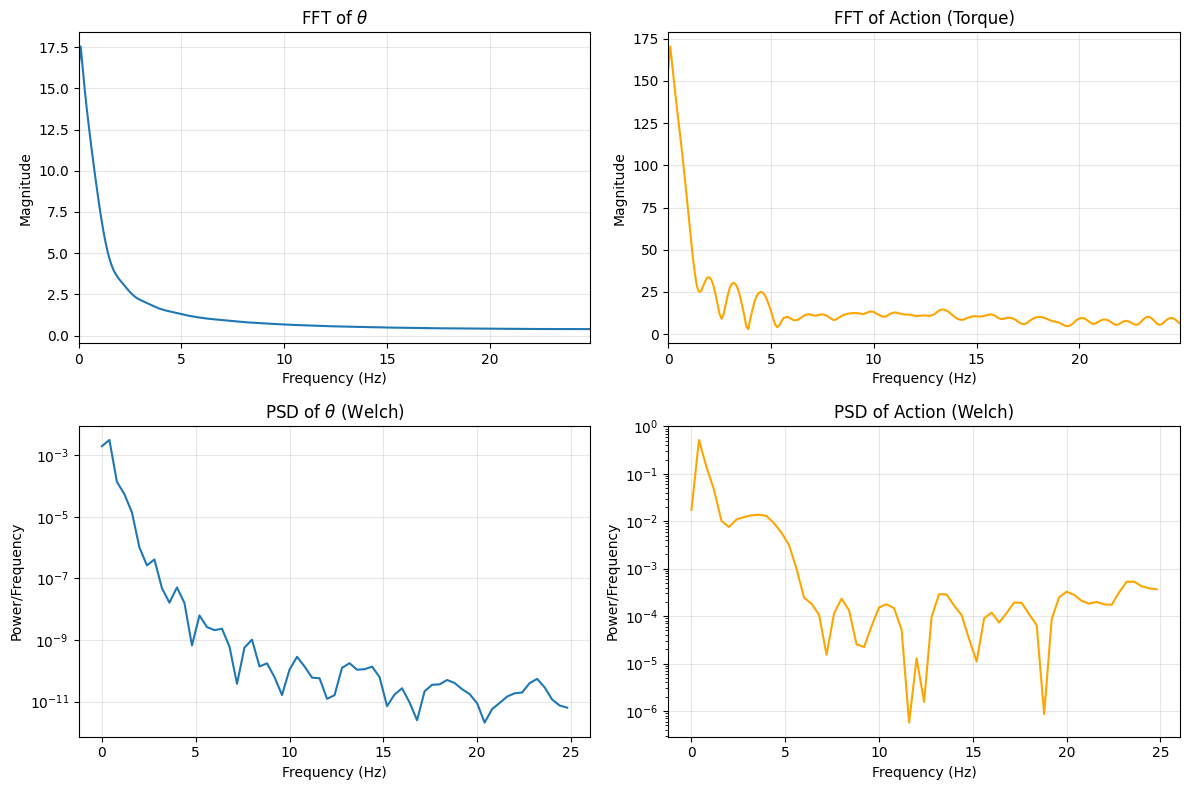

In [104]:
from scipy.fft import fft, fftfreq
from scipy.signal import welch

# Compute and plot FFT of states and actions

dt = env_noisy.unwrapped.dt  # timestep
n_samples = len(actions_45_sig)

# Compute FFT frequencies
freqs = fftfreq(n_samples, dt)[:n_samples // 2]

# Compute theta and action signals
theta = np.arctan2(states_45_sig[:-1, 1], states_45_sig[:-1, 0])  # atan2(sin, cos)
action_signal = actions_45_sig.flatten()

# Compute Power Spectral Density (PSD) using Welch's method
freqs_psd, psd_theta = welch(theta, fs=1/dt, nperseg=len(theta)//4)
freqs_psd, psd_action = welch(action_signal, fs=1/dt, nperseg=len(action_signal)//4)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# FFT plots (top row)
ax = axes[0, 0]
fft_vals = np.abs(fft(theta))[:n_samples // 2]
ax.plot(freqs, fft_vals)
ax.set_title(r'FFT of $\theta$')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
fft_actions = np.abs(fft(action_signal))[:n_samples // 2]
ax.plot(freqs, fft_actions, color='orange')
ax.set_title('FFT of Action (Torque)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

# PSD plots (bottom row)
ax = axes[1, 0]
ax.semilogy(freqs_psd, psd_theta)
ax.set_title(r'PSD of $\theta$ (Welch)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.semilogy(freqs_psd, psd_action, color='orange')
ax.set_title('PSD of Action (Welch)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Deepmind type reward function

In [105]:
class DMSigmoidFrequencyPenaltyWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        fs=20.0,
        cutoff_hz=6.0,
        lambda_penalty=0.1,
        sigmoid_scale=20.0,
        energy_bias=0.01,
        energy_decay=0.95,
    ):
        super().__init__(env)

        self.lambda_penalty = lambda_penalty
        self.sigmoid_scale = sigmoid_scale
        self.energy_bias = energy_bias
        self.energy_decay = energy_decay

        nyq = 0.5 * fs
        normalized_cutoff = cutoff_hz / nyq
        # Clamp to valid range (0, 1) for filter design
        normalized_cutoff = min(max(normalized_cutoff, 0.01), 0.99)
        self.b, self.a = butter(2, normalized_cutoff, btype="low")
        self.zi = lfilter_zi(self.b, self.a)

        self.hf_energy = 0.0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        self.hf_energy = 0.0
        return obs, info

    def step(self, action):
        u = float(action[0])
        obs, reward, terminated, truncated, info = self.env.step(action)

        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_hf = u - u_lpf[0]

        self.hf_energy = (
            self.energy_decay * self.hf_energy
            + (1 - self.energy_decay) * (u_hf ** 2)
        )

        hf_score = 1.0 / (
            1.0 + np.exp(-self.sigmoid_scale * (self.hf_energy - self.energy_bias))
        )

        reward += -self.lambda_penalty * hf_score  # Penalize HF, add to task reward

        info.update({
            "hf_energy": self.hf_energy,
            "hf_score": hf_score,
            "u_hf": u_hf,
        })

        return obs, reward, terminated, truncated, info

In [106]:
# Wrap noisy env with DM-style sigmoid penalty for training
env_dm = DMSigmoidFrequencyPenaltyWrapper(env_noisy, fs=20.0, cutoff_hz=10.0)

In [107]:
model_dm = SAC(
    "MlpPolicy",
    env_dm,
    learning_rate=3e-4,
    gamma=0.99,
    # verbose=1,
)

In [108]:
model_dm.learn(total_timesteps=100_000)

In [109]:
# Rollout on base noisy env (no penalty wrapper)
states_45_dm, actions_45_dm, rewards_45_dm = rollout_sb3_debug(env_noisy, model_dm, start_angle=np.pi/4, start_velocity=0.0)

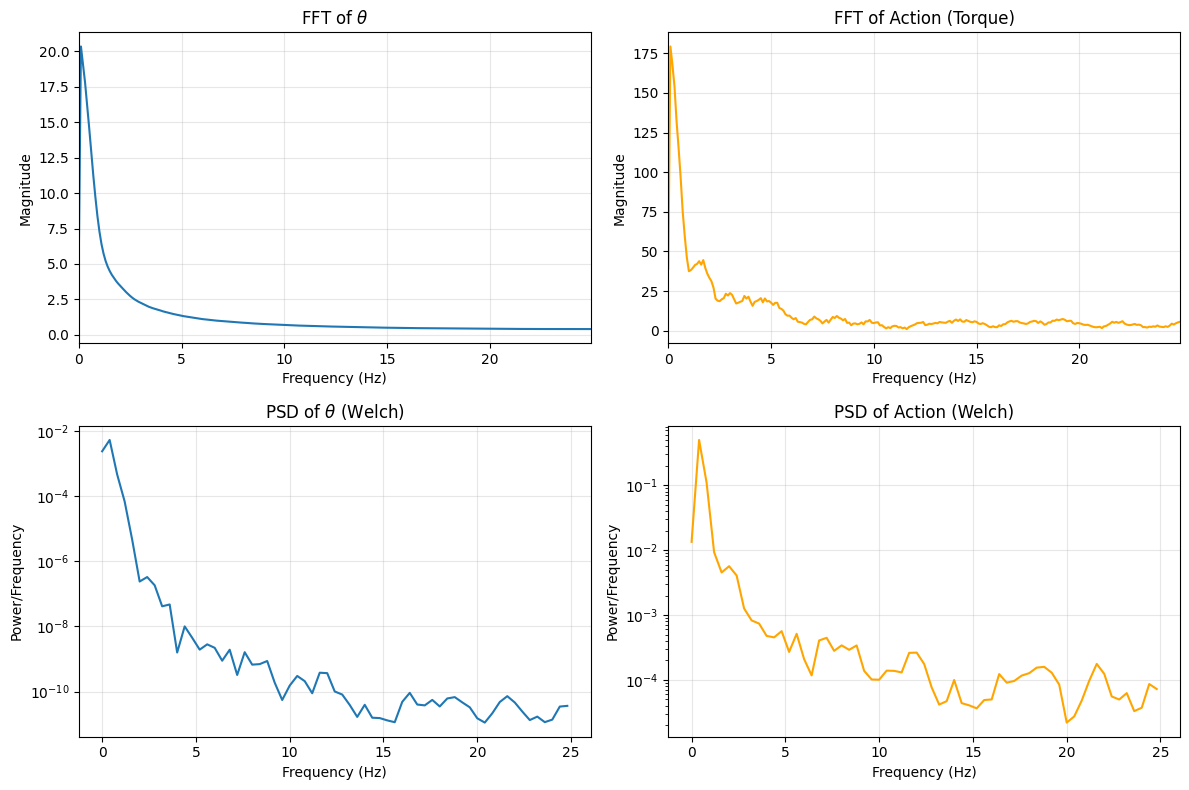

In [110]:
from scipy.fft import fft, fftfreq
from scipy.signal import welch

# Compute and plot FFT of states and actions

dt = env_noisy.unwrapped.dt  # timestep
n_samples = len(actions_45_dm)

# Compute FFT frequencies
freqs = fftfreq(n_samples, dt)[:n_samples // 2]

# Compute theta and action signals
theta = np.arctan2(states_45_dm[:-1, 1], states_45_dm[:-1, 0])  # atan2(sin, cos)
action_signal = actions_45_dm.flatten()

# Compute Power Spectral Density (PSD) using Welch's method
freqs_psd, psd_theta = welch(theta, fs=1/dt, nperseg=len(theta)//4)
freqs_psd, psd_action = welch(action_signal, fs=1/dt, nperseg=len(action_signal)//4)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# FFT plots (top row)
ax = axes[0, 0]
fft_vals = np.abs(fft(theta))[:n_samples // 2]
ax.plot(freqs, fft_vals)
ax.set_title(r'FFT of $\theta$')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
fft_actions = np.abs(fft(action_signal))[:n_samples // 2]
ax.plot(freqs, fft_actions, color='orange')
ax.set_title('FFT of Action (Torque)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

# PSD plots (bottom row)
ax = axes[1, 0]
ax.semilogy(freqs_psd, psd_theta)
ax.set_title(r'PSD of $\theta$ (Welch)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency')
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
ax.semilogy(freqs_psd, psd_action, color='orange')
ax.set_title('PSD of Action (Welch)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparison of All Models

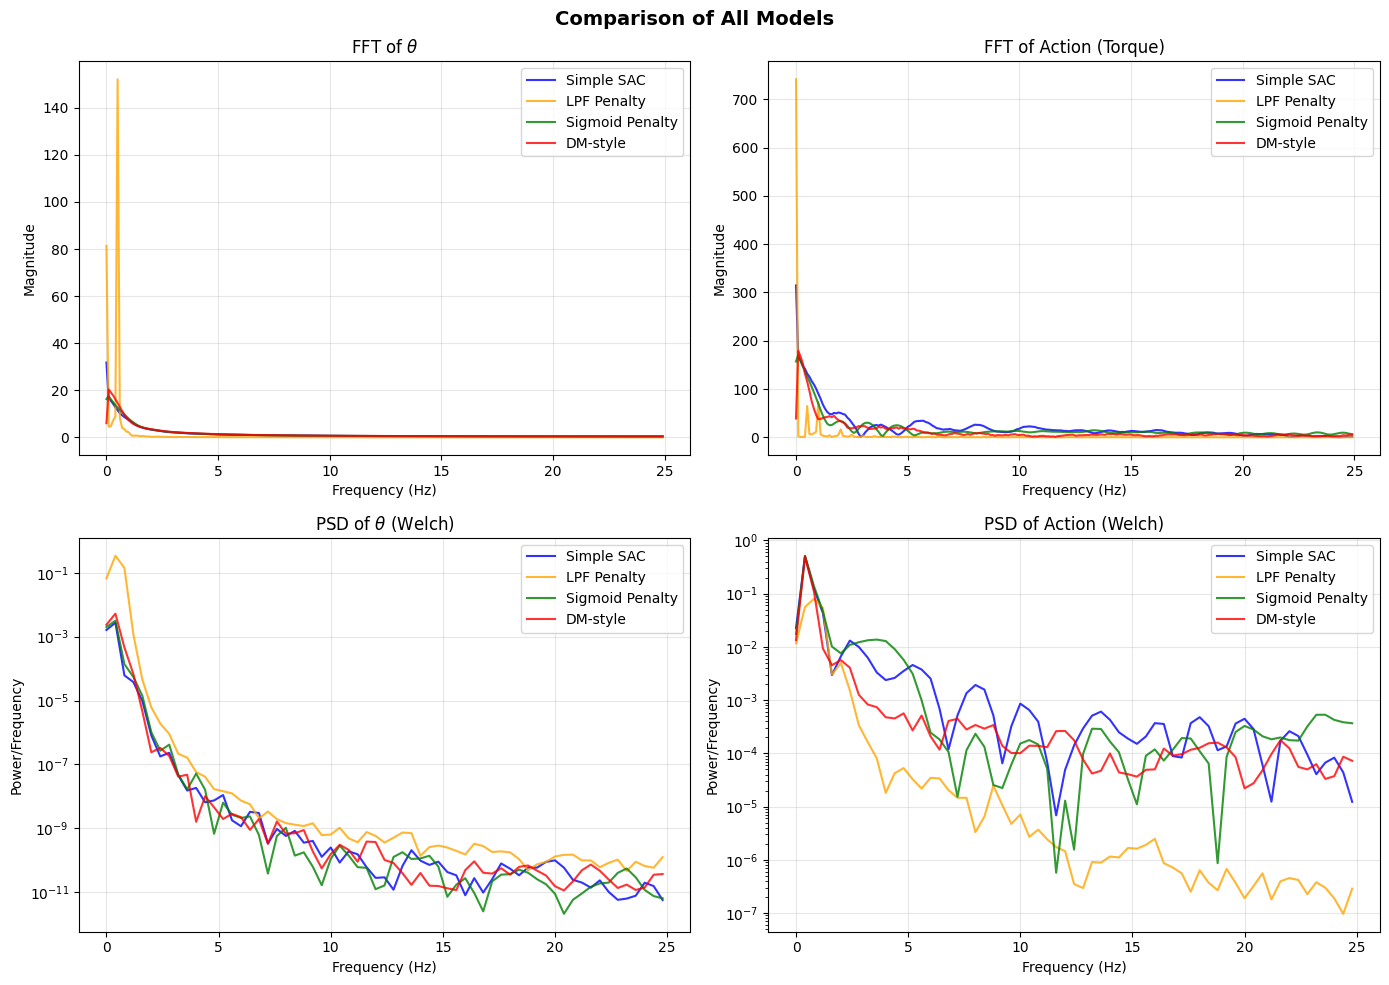

In [111]:
from scipy.fft import fft, fftfreq
from scipy.signal import welch

dt = env_noisy.unwrapped.dt

# Define models and their data
models_data = {
    'Simple SAC': (states_45_simple, actions_45_simple),
    'LPF Penalty': (states_45_LPF, actions_45_LPF),
    'Sigmoid Penalty': (states_45_sig, actions_45_sig),
    'DM-style': (states_45_dm, actions_45_dm),
}

colors = ['blue', 'orange', 'green', 'red']

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for (name, (states, actions)), color in zip(models_data.items(), colors):
    n_samples = len(actions)
    freqs = fftfreq(n_samples, dt)[:n_samples // 2]
    
    # Compute theta and action signals
    theta = np.arctan2(states[:-1, 1], states[:-1, 0])
    action_signal = actions.flatten()
    
    # FFT
    fft_theta = np.abs(fft(theta))[:n_samples // 2]
    fft_actions = np.abs(fft(action_signal))[:n_samples // 2]
    
    # PSD
    freqs_psd, psd_theta = welch(theta, fs=1/dt, nperseg=len(theta)//4)
    freqs_psd, psd_action = welch(action_signal, fs=1/dt, nperseg=len(action_signal)//4)
    
    # Plot FFT of theta
    axes[0, 0].plot(freqs, fft_theta, color=color, label=name, alpha=0.8)
    
    # Plot FFT of action
    axes[0, 1].plot(freqs, fft_actions, color=color, label=name, alpha=0.8)
    
    # Plot PSD of theta
    axes[1, 0].semilogy(freqs_psd, psd_theta, color=color, label=name, alpha=0.8)
    
    # Plot PSD of action
    axes[1, 1].semilogy(freqs_psd, psd_action, color=color, label=name, alpha=0.8)

# Configure axes
axes[0, 0].set_title(r'FFT of $\theta$')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Magnitude')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_title('FFT of Action (Torque)')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Magnitude')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_title(r'PSD of $\theta$ (Welch)')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Power/Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_title('PSD of Action (Welch)')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Power/Frequency')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Comparison of All Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

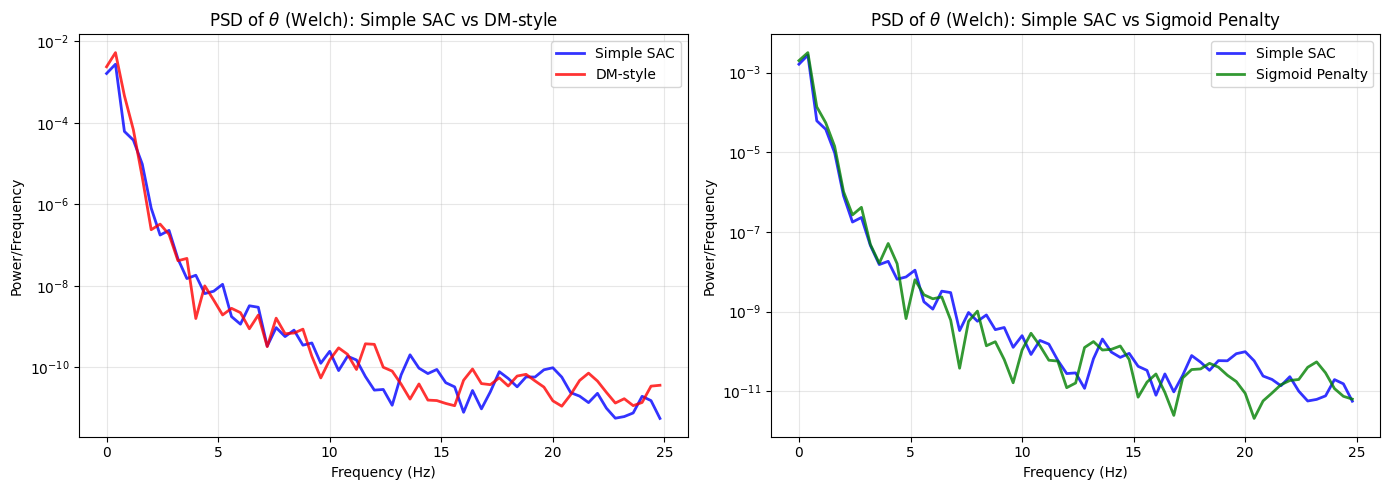

In [112]:
from scipy.fft import fft, fftfreq
from scipy.signal import welch

dt = env_noisy.unwrapped.dt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Simple SAC vs DM-style
ax = axes[0]
for name, states, color in [('Simple SAC', states_45_simple, 'blue'), ('DM-style', states_45_dm, 'red')]:
    theta = np.arctan2(states[:-1, 1], states[:-1, 0])
    freqs_psd, psd_theta = welch(theta, fs=1/dt, nperseg=len(theta)//4)
    ax.semilogy(freqs_psd, psd_theta, color=color, label=name, alpha=0.8, linewidth=2)

ax.set_title(r'PSD of $\theta$ (Welch): Simple SAC vs DM-style')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

# Right plot: Simple SAC vs Sigmoid Penalty
ax = axes[1]
for name, states, color in [('Simple SAC', states_45_simple, 'blue'), ('Sigmoid Penalty', states_45_sig, 'green')]:
    theta = np.arctan2(states[:-1, 1], states[:-1, 0])
    freqs_psd, psd_theta = welch(theta, fs=1/dt, nperseg=len(theta)//4)
    ax.semilogy(freqs_psd, psd_theta, color=color, label=name, alpha=0.8, linewidth=2)

ax.set_title(r'PSD of $\theta$ (Welch): Simple SAC vs Sigmoid Penalty')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power/Frequency')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [113]:
# Improved Methods

In [114]:
# Method 1: Simple Action Rate Penalty (penalize rapid action changes)
class ActionRatePenaltyWrapper(gym.Wrapper):
    """
    Penalizes rapid action changes - a simple and effective way to reduce HF content.
    No filter design needed.
    """
    def __init__(self, env, lambda_rate=0.1):
        super().__init__(env)
        self.lambda_rate = lambda_rate
        self.prev_action = 0.0
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.prev_action = 0.0
        return obs, info
    
    def step(self, action):
        u = float(action[0])
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Penalize rapid action changes (high frequency = rapid changes)
        rate_penalty = -self.lambda_rate * (u - self.prev_action)**2
        reward += rate_penalty
        
        self.prev_action = u
        return obs, reward, terminated, truncated, info

In [115]:
# Method 2: Combined LPF + Rate Penalty (recommended)
class CombinedPenaltyWrapper(gym.Wrapper):
    """
    Combines LPF-based HF penalty with action rate penalty for better noise attenuation.
    """
    def __init__(
        self, 
        env, 
        lambda_hf=0.3,      # HF penalty weight (increased)
        lambda_rate=0.1,    # Action rate penalty weight
        cutoff_hz=5.0,      # Lower cutoff for realistic control bandwidth
        fs=50.0             # Sampling frequency
    ):
        super().__init__(env)
        self.lambda_hf = lambda_hf
        self.lambda_rate = lambda_rate
        self.prev_action = 0.0
        
        # LPF to extract HF component via residual
        nyq = 0.5 * fs
        normalized_cutoff = min(max(cutoff_hz / nyq, 0.01), 0.99)
        self.b, self.a = butter(2, normalized_cutoff, btype="low")
        self.zi = lfilter_zi(self.b, self.a)
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        self.prev_action = 0.0
        return obs, info
    
    def step(self, action):
        u = float(action[0])
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # HF penalty via LPF residual
        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_hf = u - u_lpf[0]
        hf_penalty = -self.lambda_hf * u_hf**2
        
        # Action rate penalty
        rate_penalty = -self.lambda_rate * (u - self.prev_action)**2
        self.prev_action = u
        
        reward += hf_penalty + rate_penalty
        
        info['hf_penalty'] = hf_penalty
        info['rate_penalty'] = rate_penalty
        
        return obs, reward, terminated, truncated, info

In [116]:
# Method 3: Improved DM-style with better parameters
class ImprovedDMWrapper(gym.Wrapper):
    """
    Improved DM-style with lower cutoff, stronger penalty, and better sigmoid parameters.
    """
    def __init__(
        self,
        env,
        fs=50.0,
        cutoff_hz=5.0,        # Lower cutoff
        lambda_penalty=0.5,    # Stronger penalty
        sigmoid_scale=50.0,    # Sharper transition
        energy_bias=0.005,     # Lower threshold
        energy_decay=0.9,      # Faster response
    ):
        super().__init__(env)

        self.lambda_penalty = lambda_penalty
        self.sigmoid_scale = sigmoid_scale
        self.energy_bias = energy_bias
        self.energy_decay = energy_decay

        nyq = 0.5 * fs
        normalized_cutoff = min(max(cutoff_hz / nyq, 0.01), 0.99)
        self.b, self.a = butter(2, normalized_cutoff, btype="low")
        self.zi = lfilter_zi(self.b, self.a)

        self.hf_energy = 0.0

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        self.hf_energy = 0.0
        return obs, info

    def step(self, action):
        u = float(action[0])
        obs, reward, terminated, truncated, info = self.env.step(action)

        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_hf = u - u_lpf[0]

        self.hf_energy = (
            self.energy_decay * self.hf_energy
            + (1 - self.energy_decay) * (u_hf ** 2)
        )

        hf_score = 1.0 / (
            1.0 + np.exp(-self.sigmoid_scale * (self.hf_energy - self.energy_bias))
        )

        reward += -self.lambda_penalty * hf_score

        info.update({
            "hf_energy": self.hf_energy,
            "hf_score": hf_score,
            "u_hf": u_hf,
        })

        return obs, reward, terminated, truncated, info

## Train Action Rate Penalty

In [ ]:
# Create training environment with action rate penalty
env_rate = ActionRatePenaltyWrapper(
    ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    lambda_rate=0.1
)

# Train SAC model
model_rate = SAC("MlpPolicy", env_rate, verbose=1)
model_rate.learn(total_timesteps=100_000)
print("Action Rate Penalty model trained!")

## Train Combined Penalty (LPF Residual + Rate)

In [ ]:
# Create training environment with combined penalty
env_combined = CombinedPenaltyWrapper(
    ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    cutoff_hz=5.0,
    fs=50.0,  # Match actual dt=0.02
    lambda_hf=0.3,    # Changed from lambda_lpf to match wrapper definition
    lambda_rate=0.1
)

# Train SAC model
model_combined = SAC("MlpPolicy", env_combined, verbose=1)
model_combined.learn(total_timesteps=100_000)
print("Combined Penalty model trained!")

## Train Improved DM-style

In [ ]:
# Create training environment with improved DM-style
env_improved_dm = ImprovedDMWrapper(
    ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10),
    cutoff_hz=5.0,
    fs=50.0,  # Match actual dt=0.02
    lambda_penalty=0.5,
    sigmoid_scale=50.0,
    energy_bias=0.005,
    energy_decay=0.9
)

# Train SAC model
model_improved_dm = SAC("MlpPolicy", env_improved_dm, verbose=1)
model_improved_dm.learn(total_timesteps=100_000)
print("Improved DM-style model trained!")

## Rollout All Improved Methods

In [ ]:
# Rollout all improved methods on the SAME noisy environment for fair comparison
# Use env_noisy (base_env with noise wrapper) for all rollouts

def rollout_improved(model, env, n_steps=1000):
    """Rollout and collect actions from a model."""
    obs, _ = env.reset()
    actions = []
    for _ in range(n_steps):
        action, _ = model.predict(obs, deterministic=True)
        actions.append(action[0])
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            obs, _ = env.reset()
    return np.array(actions)

# Create fresh noisy env for rollouts
rollout_env = ActionGaussianNoiseWrapper(MuJoCoPendulumEnv(), snr_linear=10)

# Rollout all improved methods
print("Rolling out Action Rate Penalty model...")
actions_rate = rollout_improved(model_rate, rollout_env)

print("Rolling out Combined Penalty model...")
actions_combined = rollout_improved(model_combined, rollout_env)

print("Rolling out Improved DM-style model...")
actions_improved_dm = rollout_improved(model_improved_dm, rollout_env)

print("All rollouts complete!")

## Compare Improved Methods vs Simple SAC

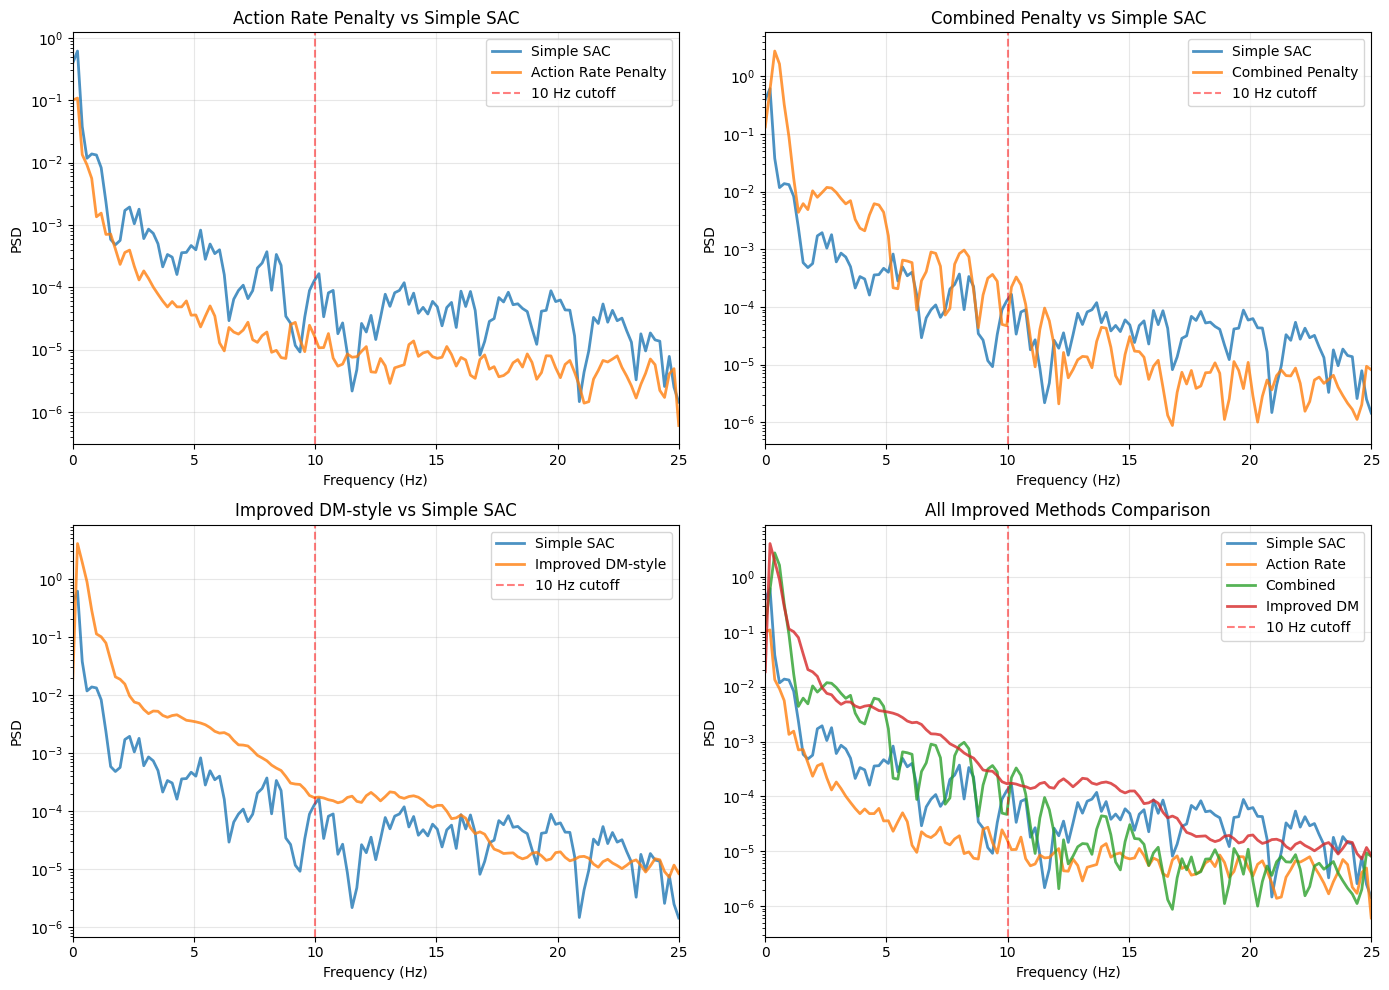


=== High-Frequency Energy (>10 Hz) as % of Total ===
Simple SAC:          0.27%
Action Rate Penalty: 0.19%
Combined Penalty:    0.03%
Improved DM-style:   0.07%


In [130]:
# Compare all improved methods against Simple SAC
from scipy.signal import welch

dt = 0.02
fs = 1 / dt  # 50 Hz

# Compute PSD for Simple SAC (reference)
freqs_simple, psd_simple = welch(actions_45_simple.flatten(), fs=fs, nperseg=256)

# Compute PSD for improved methods
freqs_rate, psd_rate = welch(actions_rate, fs=fs, nperseg=256)
freqs_combined, psd_combined = welch(actions_combined, fs=fs, nperseg=256)
freqs_improved_dm, psd_improved_dm = welch(actions_improved_dm, fs=fs, nperseg=256)

# Plot comparison - 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Top-left: Action Rate Penalty vs Simple SAC
axes[0, 0].semilogy(freqs_simple, psd_simple, label='Simple SAC', alpha=0.8, linewidth=2)
axes[0, 0].semilogy(freqs_rate, psd_rate, label='Action Rate Penalty', alpha=0.8, linewidth=2)
axes[0, 0].axvline(x=10, color='r', linestyle='--', alpha=0.5, label='10 Hz cutoff')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('PSD')
axes[0, 0].set_title('Action Rate Penalty vs Simple SAC')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim([0, 25])

# Top-right: Combined Penalty vs Simple SAC
axes[0, 1].semilogy(freqs_simple, psd_simple, label='Simple SAC', alpha=0.8, linewidth=2)
axes[0, 1].semilogy(freqs_combined, psd_combined, label='Combined Penalty', alpha=0.8, linewidth=2)
axes[0, 1].axvline(x=10, color='r', linestyle='--', alpha=0.5, label='10 Hz cutoff')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('PSD')
axes[0, 1].set_title('Combined Penalty vs Simple SAC')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0, 25])

# Bottom-left: Improved DM-style vs Simple SAC
axes[1, 0].semilogy(freqs_simple, psd_simple, label='Simple SAC', alpha=0.8, linewidth=2)
axes[1, 0].semilogy(freqs_improved_dm, psd_improved_dm, label='Improved DM-style', alpha=0.8, linewidth=2)
axes[1, 0].axvline(x=10, color='r', linestyle='--', alpha=0.5, label='10 Hz cutoff')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('PSD')
axes[1, 0].set_title('Improved DM-style vs Simple SAC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 25])

# Bottom-right: All improved methods together
axes[1, 1].semilogy(freqs_simple, psd_simple, label='Simple SAC', alpha=0.8, linewidth=2)
axes[1, 1].semilogy(freqs_rate, psd_rate, label='Action Rate', alpha=0.8, linewidth=2)
axes[1, 1].semilogy(freqs_combined, psd_combined, label='Combined', alpha=0.8, linewidth=2)
axes[1, 1].semilogy(freqs_improved_dm, psd_improved_dm, label='Improved DM', alpha=0.8, linewidth=2)
axes[1, 1].axvline(x=10, color='r', linestyle='--', alpha=0.5, label='10 Hz cutoff')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('PSD')
axes[1, 1].set_title('All Improved Methods Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 25])

plt.tight_layout()
plt.savefig('improved_methods_comparison.png', dpi=150)
plt.show()

# Print HF energy metrics
def compute_hf_energy(freqs, psd, cutoff=10):
    """Compute energy above cutoff frequency."""
    hf_mask = freqs > cutoff
    total = np.sum(psd)
    hf = np.sum(psd[hf_mask])
    return hf / total * 100

print("\n=== High-Frequency Energy (>10 Hz) as % of Total ===")
print(f"Simple SAC:          {compute_hf_energy(freqs_simple, psd_simple):.2f}%")
print(f"Action Rate Penalty: {compute_hf_energy(freqs_rate, psd_rate):.2f}%")
print(f"Combined Penalty:    {compute_hf_energy(freqs_combined, psd_combined):.2f}%")
print(f"Improved DM-style:   {compute_hf_energy(freqs_improved_dm, psd_improved_dm):.2f}%")